<a href="https://colab.research.google.com/github/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/10/1024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install umap-learn[plot] hdbscan
!wget -O 1024_class.csv https://github.com/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/data/1024_class.csv?raw=1
!wget -O 1024_zoo.csv https://github.com/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/data/1024_zoo.csv?raw=1

## HDBSCAN for categorical data

In [2]:
# !{sys.executable} -m pip install hdbscan
import pandas as pd
import numpy as np
import seaborn as sns

import hdbscan
from hdbscan.validity import validity_index

import umap
import umap.plot as uplot

from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score

import matplotlib.pyplot as plt

sns.set_theme()

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:61: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn

### Load animal zoo dataset

The Zoo Dataset is a comprehensive collection of data about various animals found in zoos worldwide. The dataset is composed of several attributes related to these animals, such as:

- `animal_name`: The name of the animal.

- `hair`: Indicates if the animal has hair (1 for yes, 0 for no).
- `feathers`: Indicates if the animal has feathers (1 for yes, 0 for no).
- `eggs`: Indicates if the animal lays eggs (1 for yes, 0 for no).
- `milk`: Indicates if the animal produces milk (1 for yes, 0 for no).
- `airborne`: Indicates if the animal can fly (1 for yes, 0 for no).
- `aquatic`: Indicates if the animal lives in water (1 for yes, 0 for no).
- `predator`: Indicates if the animal is a predator (1 for yes, 0 for no).
- `toothed`: Indicates if the animal has teeth (1 for yes, 0 for no).
- `backbone`: Indicates if the animal has a backbone (1 for yes, 0 for no).
- `breathes`: Indicates if the animal breathes air (1 for yes, 0 for no).
- `venomous`: Indicates if the animal is venomous (1 for yes, 0 for no).
- `fins`: Indicates if the animal has fins (1 for yes, 0 for no).
- `legs`: Number of legs the animal has (integer value).
- `tail`: Indicates if the animal has a tail (1 for yes, 0 for no).
- `domestic`: Indicates if the animal is domesticated (1 for yes, 0 for no).
- `catsize`: Indicates if the animal is cat-sized or larger (1 for yes, 0 for no).
- `class_type`: Numerical code indicating the animal's taxonomic class.


Citation : Forsyth,Richard. (1990). Zoo. UCI Machine Learning Repository. https://doi.org/10.24432/C5R59V.

In [4]:
# Load the data
zoo_path = '1024_zoo.csv'
zoo_df = pd.read_csv(zoo_path)

# Load class mapping
class_mappings = '1024_class.csv'
class_mapper = pd.read_csv(class_mappings)

In [5]:
zoo_df.head()

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1


In [6]:
class_mapper

,Class_Number,Number_Of_Animal_Species_In_Class,Class_Type,Animal_Names
0,1,41,Mammal,"aardvark, antelope, bear, boar, buffalo, calf,..."
1,2,20,Bird,"chicken, crow, dove, duck, flamingo, gull, haw..."
2,3,5,Reptile,"pitviper, seasnake, slowworm, tortoise, tuatara"
3,4,13,Fish,"bass, carp, catfish, chub, dogfish, haddock, h..."
4,5,4,Amphibian,"frog, frog, newt, toad"
5,6,8,Bug,"flea, gnat, honeybee, housefly, ladybird, moth..."
6,7,10,Invertebrate,"clam, crab, crayfish, lobster, octopus, scorpi..."


In [7]:
zoo_df.shape

(101, 18)

In [8]:
zoo_df.isna().sum(axis=0)

,0
animal_name,0
hair,0
feathers,0
eggs,0
milk,0
airborne,0
aquatic,0
predator,0
toothed,0
backbone,0


In [9]:
# Check number of unique animals
zoo_df['animal_name'].nunique()

100

In [10]:
# Drop duplicates since there should be one species per row
zoo_df = zoo_df.drop_duplicates('animal_name')
zoo_df.shape

(100, 18)

In [11]:
# Map class id to class name
class_map_dict = class_mapper.set_index('Class_Number')['Class_Type'].to_dict()
zoo_df['class_type'] = zoo_df['class_type'].map(class_map_dict)

# Extract class as separate object and drop class from zoo_df
animal_class = zoo_df['class_type']
zoo_df = zoo_df.drop(columns=['class_type'])

<ipython-input-11-da31989dda0b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zoo_df['class_type'] = zoo_df['class_type'].map(class_map_dict)


In [12]:
# Set animal name as index
zoo_df = zoo_df.set_index('animal_name', drop=True)

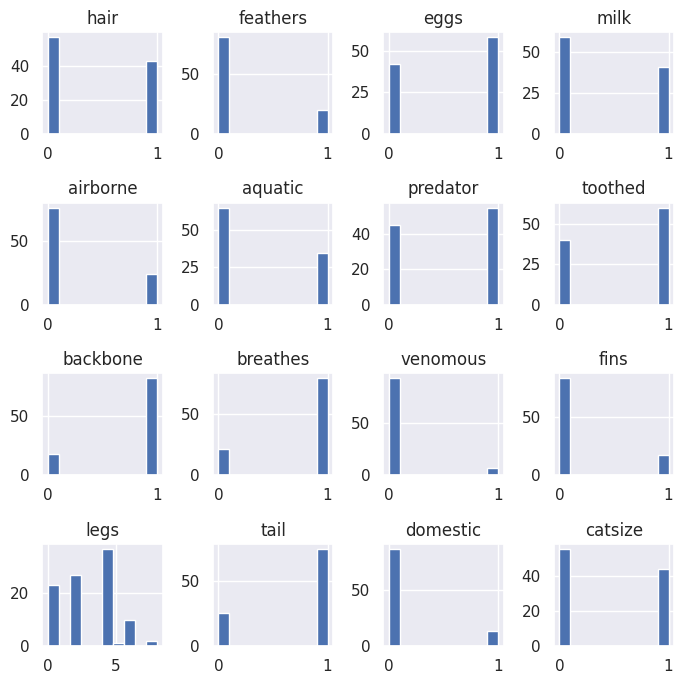

In [13]:
_ = zoo_df.hist(figsize=(7,7))
plt.tight_layout()

In [14]:
zoo_umap = umap.UMAP(metric='hamming', n_neighbors=20).fit(zoo_df.values)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1880: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


<Axes: >

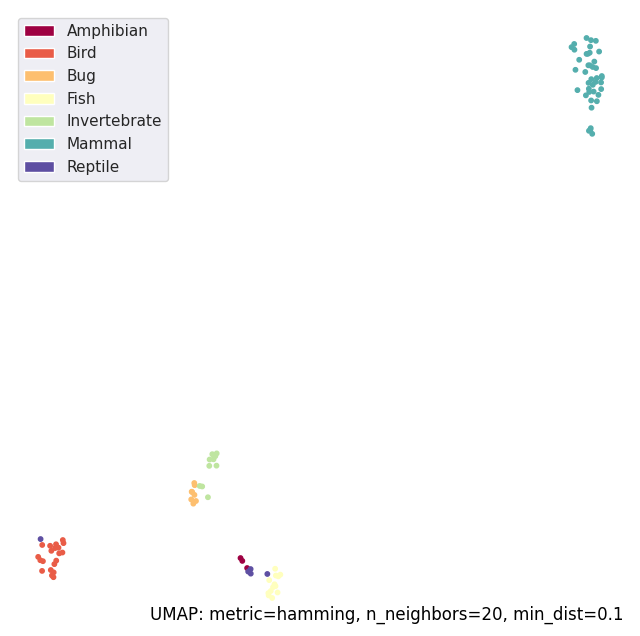

In [15]:
uplot.points(zoo_umap, labels=animal_class)

### HDBSCAN clustering

In [16]:
# we will evaluate clustering by taking into consideration the whole data set,
# but also by taking into consideration only the non outlier data points
def print_clustering_stats(clusterer, data_df, data_labels, metric):
    # Create reduced version of data (exclude noise)
    np_labels = np.array(clusterer.labels_)
    non_noise_idx = np.where(np_labels != -1)

    non_noise_labels = np_labels[non_noise_idx]
    data_labels_sub = data_labels[non_noise_idx]
    digits_data_sub = data_df[non_noise_idx]
    noise_size = np_labels.shape[0] - non_noise_labels.shape[0]

    print('ARI : {}'.format(adjusted_rand_score(np_labels, data_labels)))
    print('ARI sub : {}'.format(adjusted_rand_score(non_noise_labels, data_labels_sub)))
    print('noise size : {}'.format(noise_size))
    print('Silouethe : {}'.format(silhouette_score(data_df, np_labels, metric=metric)))
    print('Silouethe sub : {}'.format(silhouette_score(digits_data_sub, data_labels_sub, metric=metric)))
    print('DBCV : {}'.format(validity_index(data_df, np_labels, metric=metric)))

ARI : 0.7873258707294175
ARI sub : 0.9472349123380245
noise size : 15
Silouethe : 0.505347858056519
Silouethe sub : 0.5572158704064776
DBCV : 0.4972328474655528


<Axes: >

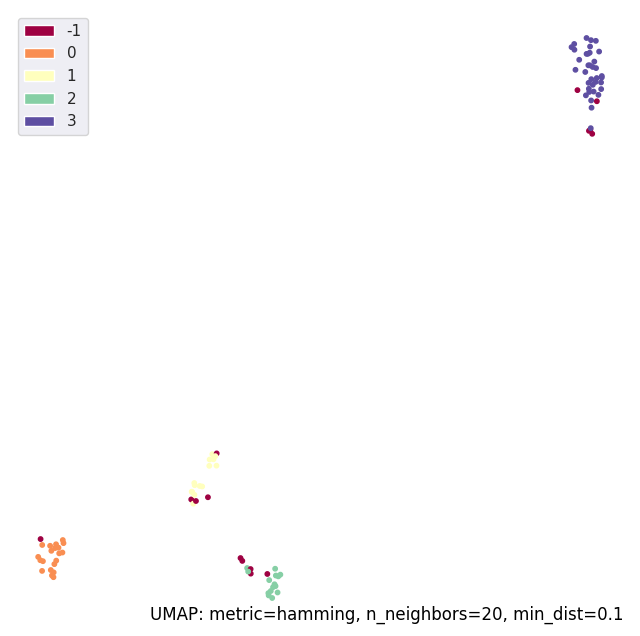

In [17]:
clusterer = hdbscan.HDBSCAN(
    min_samples=5,
    min_cluster_size=10,
    gen_min_span_tree=True,
    metric='hamming'
)
clusterer.fit(zoo_df.values)

print_clustering_stats(
    clusterer=clusterer,
    data_df=zoo_df.values,
    data_labels=animal_class.values,
    metric='hamming'
)

uplot.points(zoo_umap, labels=clusterer.labels_)
# this clustering isn't half bad
# we have managed to identify our main categories
# our adjusted run scores are quite high as well as silhouette scores and dbv
# but maybe we can tweak our parameters in order to increase the granularity, and also to reduce the number of noise data points

ARI : 0.8690323186962794
ARI sub : 0.8725893720343779
noise size : 1
Silouethe : 0.5287850741380472
Silouethe sub : 0.543800872787188
DBCV : 0.22208875369269132


<Axes: >

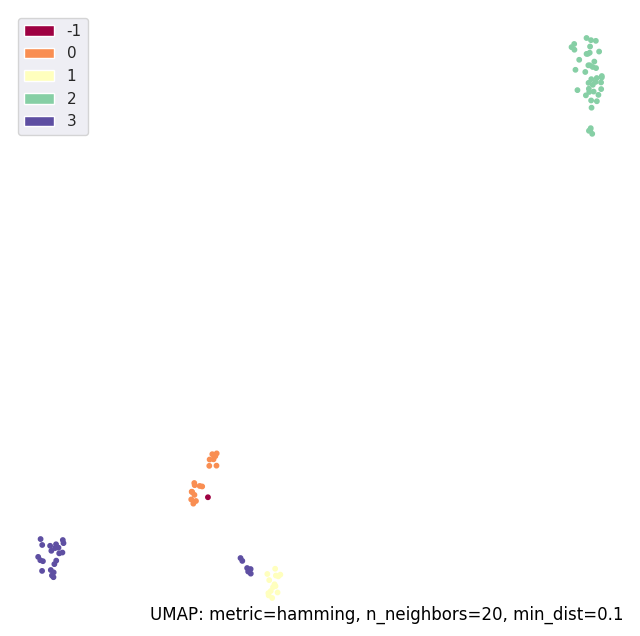

In [18]:
clusterer = hdbscan.HDBSCAN(
    min_samples=2, # reduce the values for both of our parameters
    min_cluster_size=7,
    gen_min_span_tree=True,
    metric='hamming'
)
clusterer.fit(zoo_df.values)

print_clustering_stats(
    clusterer=clusterer,
    data_df=zoo_df.values,
    data_labels=animal_class.values,
    metric='hamming'
)

uplot.points(zoo_umap, labels=clusterer.labels_)
# we have managed to to improve the quality of our clustering and also to reduce the noise size